# 99_problems_but_a_batch_aint_one
VITMAV45 - Deep Learning a gyakorlatban Python és LUA alapon - Nagy házi feladat projekt

Téma: Airbus Ship Detection Challange

A csapat tagjai:  
Bologa Eduárd ()  
Pünkösti Györk ()  
Kozma Szabolcs (TKGQWN)  

In [35]:
import os, json, pandas as pd

os.listdir("/kaggle/input")

['airbus-ship-detection-data-visualization', 'airbus-ship-detection']

In [27]:
# ==== Paths, load CSV ====
import os, json, pandas as pd, numpy as np

DATA_DIR = "/kaggle/input/airbus-ship-detection"
TRAIN_DIR = os.path.join(DATA_DIR, "train_v2")
TEST_DIR  = os.path.join(DATA_DIR, "test_v2")
CSV_PATH  = os.path.join(DATA_DIR, "train_ship_segmentations_v2.csv")

labels = pd.read_csv(CSV_PATH)
labels["has_ship"] = labels["EncodedPixels"].notna().astype(int)

# Egy képhez több sor is lehet (több hajó). Képszintű státusz:
img_status = labels.groupby("ImageId")["has_ship"].max().reset_index()

print("Képek száma (train):", img_status["ImageId"].nunique())
print("Hajós képek aránya:", img_status["has_ship"].mean().round(3))
print("Train könyvtár fájlszám:", len(os.listdir(TRAIN_DIR)))
print("Test könyvtár fájlszám:", len(os.listdir(TEST_DIR)))
img_status.head()


Képek száma (train): 192556
Hajós képek aránya: 0.221
Train könyvtár fájlszám: 192556
Test könyvtár fájlszám: 15606


,ImageId,has_ship
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,1
4,0001b1832.jpg,0


Showing image: /kaggle/input/airbus-ship-detection/train_v2/637c48da8.jpg


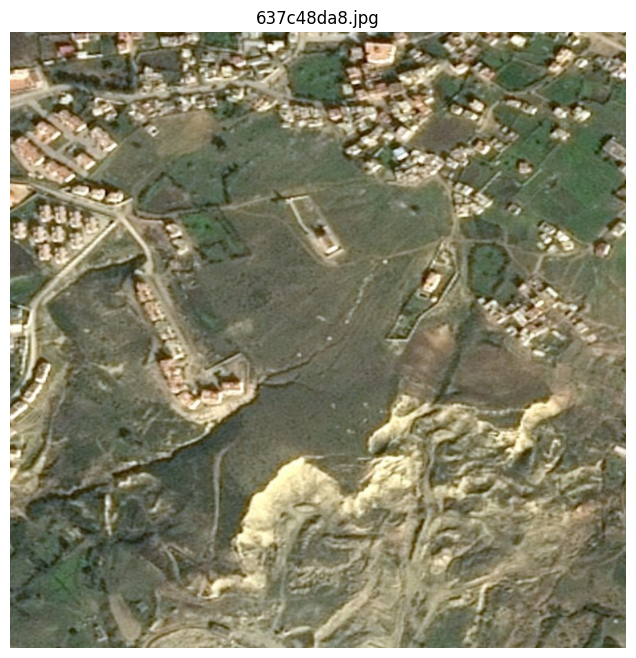

In [29]:
# ==============================
# Display one random training image
# ==============================
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# pick a random image from the training folder
random_image = random.choice(os.listdir(TRAIN_DIR))
img_path = os.path.join(TRAIN_DIR, random_image)

print("Showing image:", img_path)

# read and show the image
img = mpimg.imread(img_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title(random_image)
plt.show()


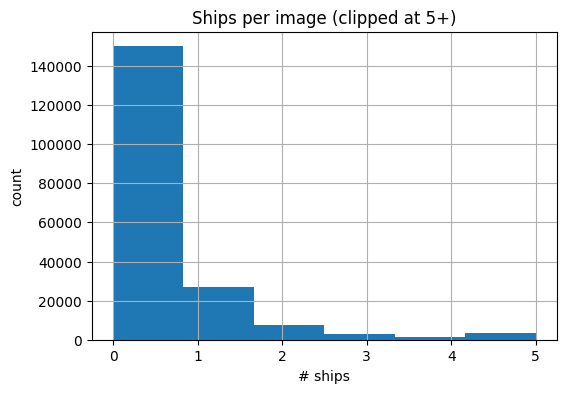

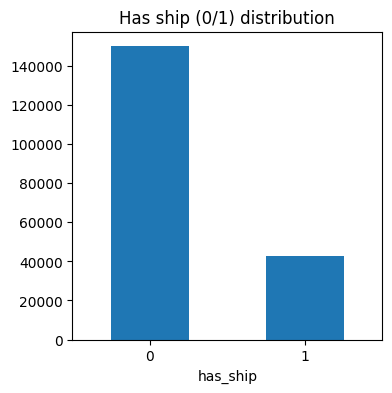

In [30]:
# ==== EDA: ships per image, osztályegyensúly ====
import matplotlib.pyplot as plt

ships_per_image = labels.groupby("ImageId")["has_ship"].sum()
plt.figure(figsize=(6,4))
ships_per_image.clip(upper=5).hist(bins=6)  # 5+-ig vágjuk
plt.title("Ships per image (clipped at 5+)")
plt.xlabel("# ships")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(4,4))
img_status["has_ship"].value_counts().plot(kind="bar")
plt.title("Has ship (0/1) distribution")
plt.xticks(rotation=0)
plt.show()


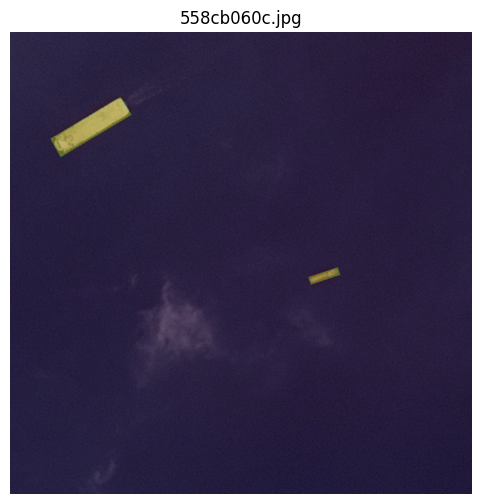

In [31]:
# ==== RLE decode helper + visualize one sample ====
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

H, W = 768, 768  # képméret ehhez a versenyhez

def rle_decode(rle, shape=(H, W)):
    if pd.isna(rle):
        return np.zeros(shape, dtype=np.uint8)
    s = list(map(int, rle.split()))
    starts, lengths = np.array(s[0::2]) - 1, np.array(s[1::2])
    ends = starts + lengths
    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = 1
    return mask.reshape(shape, order='F')  # fontos: oszlop-major (Fortran)

def show_image_with_mask(image_id):
    img_path = os.path.join(TRAIN_DIR, image_id)
    img = mpimg.imread(img_path)

    # az adott képhez tartozó RLE-k összege (több hajó esetén több sor)
    rles = labels.loc[labels["ImageId"]==image_id, "EncodedPixels"].tolist()
    mask = np.zeros((H,W), dtype=np.uint8)
    for r in rles:
        mask |= rle_decode(r)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.imshow(mask, alpha=0.35)  # átlátszó maszk
    plt.title(image_id)
    plt.axis('off')
    plt.show()

# egy random, hajót tartalmazó kép megjelenítése
pos_ids = img_status.query("has_ship==1")["ImageId"].tolist()
show_image_with_mask(random.choice(pos_ids))


In [32]:
# ==== Stratified split on image-level has_ship ====
from sklearn.model_selection import train_test_split

ids = img_status.copy()
X = ids["ImageId"].values
y = ids["has_ship"].values

# train vs temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# val vs test (fele-fele a 20%-ból)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train: {len(X_train)}  Val: {len(X_val)}  Test: {len(X_test)}")
print("Class balance (train):", np.mean(y_train).round(3),
      "val:", np.mean(y_val).round(3),
      "test:", np.mean(y_test).round(3))


Train: 154044  Val: 19256  Test: 19256
Class balance (train): 0.221 val: 0.221 test: 0.221


In [33]:
# ==== Save splits to /kaggle/working ====
OUT_DIR = "/kaggle/working/splits"
os.makedirs(OUT_DIR, exist_ok=True)

pd.Series(X_train, name="ImageId").to_csv(f"{OUT_DIR}/train_ids.csv", index=False)
pd.Series(X_val,   name="ImageId").to_csv(f"{OUT_DIR}/val_ids.csv",   index=False)
pd.Series(X_test,  name="ImageId").to_csv(f"{OUT_DIR}/test_ids.csv",  index=False)

split = {"train": X_train.tolist(), "val": X_val.tolist(), "test": X_test.tolist()}
with open(f"{OUT_DIR}/split_v1.json", "w") as f:
    json.dump(split, f)

print("Mentve:", OUT_DIR, "→", os.listdir(OUT_DIR))


Mentve: /kaggle/working/splits → ['val_ids.csv', 'test_ids.csv', 'train_ids.csv', 'split_v1.json']


In [34]:
# ==== Minimal PyTorch Dataset skeleton (képből + CSV-ből maszk) ====
from torch.utils.data import Dataset
from PIL import Image

class AirbusSegDataset(Dataset):
    def __init__(self, image_ids, img_dir=TRAIN_DIR, labels_df=labels, transform=None):
        self.image_ids = list(image_ids)
        self.img_dir   = img_dir
        self.labels_df = labels_df.set_index("ImageId")
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img = Image.open(os.path.join(self.img_dir, img_id)).convert("RGB")
        rles = self.labels_df.loc[img_id, "EncodedPixels"]
        if isinstance(rles, pd.Series):
            ms = [rle_decode(r) for r in rles.tolist()]
            mask = np.bitwise_or.reduce(ms) if ms else np.zeros((H,W), np.uint8)
        else:
            mask = rle_decode(rles)

        img = np.array(img)
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug["image"], aug["mask"]

        return img, mask.astype(np.uint8)

# példa inicializáció (transform nélkül):
train_ds = AirbusSegDataset(split["train"])
val_ds   = AirbusSegDataset(split["val"])
test_ds  = AirbusSegDataset(split["test"])  # teszten a mask üres (nincs label)
len(train_ds), len(val_ds), len(test_ds)


(154044, 19256, 19256)